<a href="https://colab.research.google.com/github/dsunsyc/AIProjects/blob/master/Logistic_Regression_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview
In our last notebook, we introduced the concept of machine learning, a method of learning a model without hardcoding instructions or rules and letting the computer converge to a optimal model. We used it to predict the age of Abalone given easily measurable metrics, like length, diameter, weight, etc. However, another important function of machine learning models is classification. For instance, the task of determining if a picture is a cat or dog, the task of classifying a body of text as containing hate speech or not, or the task of determining if a person is susceptible to a disease or not. These differ from the regression models in that there are only a set amount of output options instead of being practically any real number. 

In this notebook, we'll walk through a simple yet incredibly powerful classification algorithm, Logistic Regression. 
Logistic Regression is another popular algorithm that uses gradient descent, but it is instead used for classification tasks. 

# Environment Setup

We'll need to import some libraries to allow us to easily implement linear regression with gradient descent from scratch. 

1. First we'll need Numpy, as it'll allow us to perform matrix multiplication and other linear algebra operations. 
2. Pyplot from MatPlotLib will allow us to visualize and plot graphs about our model.
3. We'll use Pandas to load our data from a csv file stored on a github repo.
4. Seaborn will be used on top of pyplot to create some more visually aesthetic plots. 

In [2]:
# import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# location of the dataset
data_url = "https://raw.githubusercontent.com/dsunsyc/AIProjects/master/HeartDisease/processed.cleveland.csv"

# 1.0 Introduction

## 1.1 Intuition

Let's say you're a biologist and just discovered a new species of tortoise. You want to see if you can determine the sex of an individual just from weight and shell diameter. You measured a few tortoises and gathered the following data:

Weight (lbs) | Diameter (in.) | Sex
-- | -- | --
15 | 8 | F
35 | 14 | M
17 | 12 | F
20 | 17 | M
30 | 11 | M

Let's plot our data. We can distinguish between F and M individuals by using blue points for F and orange points for M.

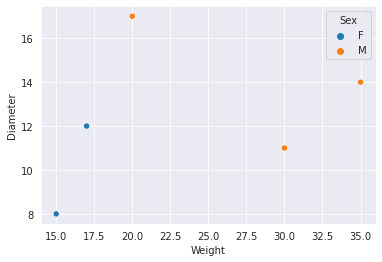

In [8]:
weight = [15, 35, 17, 20, 30]
diameter = [8, 14, 12, 17, 11]
sex = ['F', 'M', 'F', 'M', 'M']
sns.set_style("darkgrid")
df = pd.DataFrame({"Weight": weight, "Diameter": diameter, "Sex": sex})
ax = sns.scatterplot(x="Weight", y="Diameter", hue="Sex",data=df)
plt.show()

As you can see, there seems like there exists a boundary between the different classes of datapoints that would allow us to determine whether or not an individual is male or female. For instance, if we found a new tortoise with diameter of 10 inches and weight of 20 pounds, it would most likely be a female. LIkewise, if we measured a new individual with diameter of 16 inches and weight of 35 pounds, it'd most likely be a male. 

This essentially is all that classification does. It finds a decision boundary between the different classes that allows one side to be one class, and the other side to be an other class. 

How do we find a decision boundary? One method is to use Logistic Regression. 

## 1.1 Logistic Regression vs. Linear Regression

Now contrary to the name of logistic regression, it is not a regression algorithm at all. It's used for classification tasks instead. Both algorithms are predominantly used for simpler tasks, and often for linearly related data. The notebook about Linear Regression created a model that output a numerical value based on a linear relationship, or $output = a_0 + a_1x_1 + a_2x_2 + ... a_nx_n$. While this could also be used for classification tasks by using a threshold, if $output \geq t$ then example is class 1 else 0, there are two main reasons why we prefer logistic regression over that method. 



1.   The output value for linear regression is continuous. Let's say our threshold is 10. One example may output 11, while another possible outputs 100. Clearly the example labeled 100 is one that the model is more confident in compared to the example labeled as 11, yet how would we express that? 
2.   The linear regression model is also sensitive to outliers and imbalanced data. With a hard threshold, linear regression tends to be too sensitive to small outliers, resulting in much higher prediction errors. 

The key to logistic regression is the logisitic/sigmoid function. It takes the dot product, which would be the output to linear regression, and passes it through the logistic/sigmoid function. This maps all real valued, input values to a value between 0 and 1. As the input approaches negative infinity or infinity, the output value approaches either 0 or 1 respectively. 



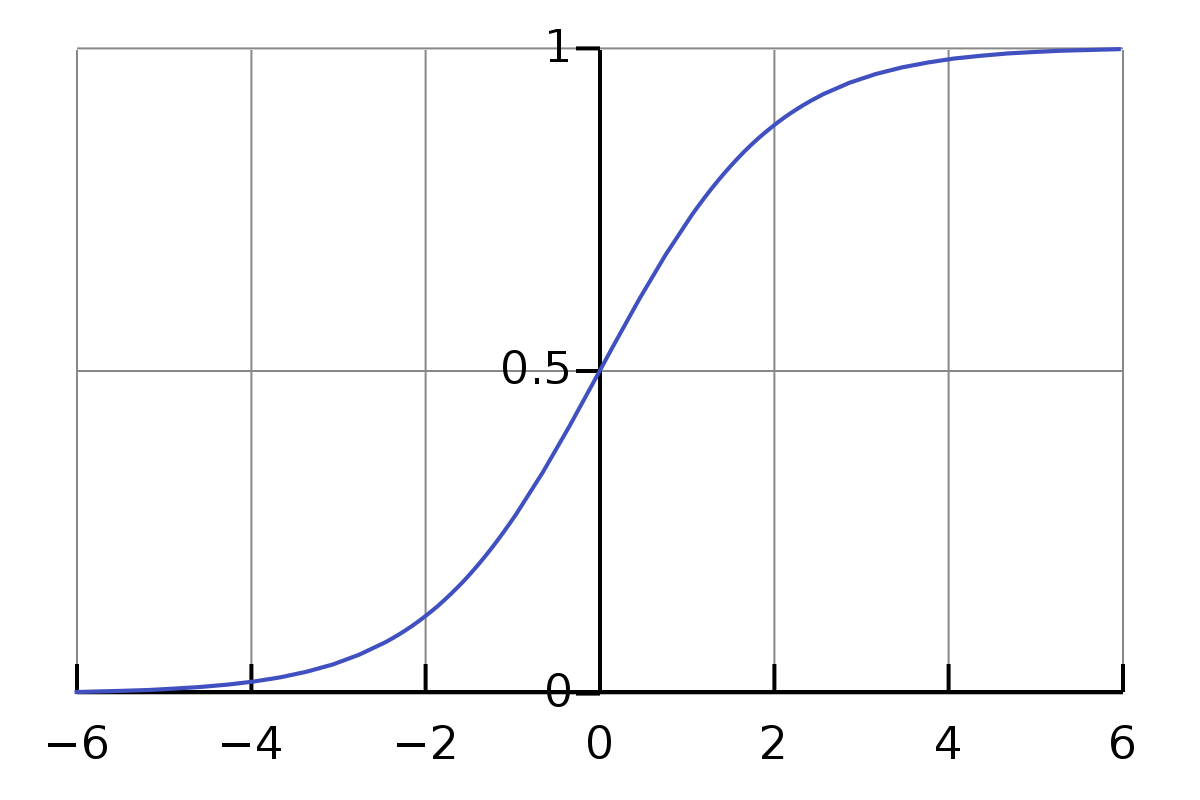


https://en.wikipedia.org/wiki/Sigmoid_function

This allows us to use the output to the logistic function as a probability of the example being class 1 or not. With the example above of a value having a weighted (dot product) value of 11 and another with a value of 100 with a hard threshold of 10, using logistic regression may instead have those examples output a .51 and .99 instead, which corresponds to a 51% chance and a 99% chance of being labeled as 1. Furthermore, logistic regression also performs much better and is less affected by imbalanced data. 

# 2.0 Building a Classifier for Predicting Heart Disease in Patients

Researchers have gathered measurements of patients with chest pain to determine if there is a relationship to having heart diseases. Doing so could allow medical practitioners identify high risk patients and work to prevent any heart disease from happening beforehand. Let's try and build a classifier that determines if a particular patient is susceptible or not to heart disease.

## 2.1 Loading the Dataset and Preprocessing

First, we obtain the dataset that we'd be working with from the raw data stored on the github repo specified by the URL defined in setup. It's always a good idea to shuffle the dataset before you split it or train with it.

We unlike last time, our new dataset has a couple examples with unknown values for features. We can remove them since it's only 6 out of 303 examples, or less than 2% of the total training data.

In [3]:
# create dataframe of our dataset csv file
df = pd.read_csv(data_url, sep=',', encoding='unicode_escape')

# our data contains 6 rows containing unknown values, which is a small portion 
# of our total data. Thus, we remove those examples from our dataset.
df = df[df.ca != '?']
df = df[df.thal != '?']

# shuffle the dataset
df = df.sample(frac=1).reset_index(drop=True).to_numpy()
m,n = df.shape
print(df[:5,:])

[[54 1 4 124 266 0 2 109 1 2.2 2 '1' '7' 1]
 [54 0 3 110 214 0 0 158 0 1.6 2 '0' '3' 0]
 [58 0 2 136 319 1 2 152 0 0.0 1 '2' '3' 3]
 [52 1 1 152 298 1 0 178 0 1.2 2 '0' '7' 0]
 [60 0 3 102 318 0 0 160 0 0.0 1 '1' '3' 0]]


Now we have our numpy array containing all the data from the patients. 
Each row represents a different patient, and the columns represent different measurements:

1.   Age of the patient
2.   Sex of the patient
3.   Type of chest pain
4.   Resting blood pressure
5.   Serum cholesterol in mg/dl
6.   Fasting blood sugar > 120 mg/dl?
7.   Resting ECG results 
8.   Maxiumum heart rate achieved
9.   Exercise induced agnina?
10.  ST depression induced by exercise
11.  Slop of the peack exercise ST segment
12.  Number of major vessels colored by fluoroscopy
13.  Thalassemia type
14.  Angiographic disease status

* More details on the different measurements can be found in the github repository.



In [4]:
# convert to an np array of type float32
df = df.astype(np.float32)
print(df[:5,:])

[[ 54.    1.    4.  124.  266.    0.    2.  109.    1.    2.2   2.    1.
    7.    1. ]
 [ 54.    0.    3.  110.  214.    0.    0.  158.    0.    1.6   2.    0.
    3.    0. ]
 [ 58.    0.    2.  136.  319.    1.    2.  152.    0.    0.    1.    2.
    3.    3. ]
 [ 52.    1.    1.  152.  298.    1.    0.  178.    0.    1.2   2.    0.
    7.    0. ]
 [ 60.    0.    3.  102.  318.    0.    0.  160.    0.    0.    1.    1.
    3.    0. ]]


We use an 70/30 training/test split for our dataset. As last time, we train our model on the training data, but to evaluate how the model performs on never-before seen examples, we then see how it does on the test set.

In [5]:
split = int(.7*m)
x_train = df[:split, :n-1]
y_train = (df[:split, -1].reshape((-1,1)) > 0).astype(int)
x_test = df[split:, :n-1]
y_test = (df[split:, -1].reshape((-1,1)) > 0).astype(int)
print(y_train.shape)

(207, 1)


## 2.2 $\theta$ Initialization

We initialize $\theta$ to be a vector of zeros. In order to be able to dot product theta with each example in our dataset, it has to be size (num features,1).
We'll pass in n (num features) as a parameter to the function.

In [6]:
def init_theta(n):
  return np.zeros((n, 1))

## 2.3 Normalization
An optimization technique to speed up the learning process is to use feature normalization. This centers all the training data at the origin as well as scaling it based on its standard deviation. 

**It's important to save the means and standard deviations of each feature, as when we try to predict using our model later on, we'd have to normalize those vectors as well.**

In [7]:
def feature_normalize(X):
  mean_arr = X.mean(axis=0)
  std_arr = X.std(axis=0)
  return ((X-mean_arr)/(std_arr), mean_arr, std_arr)

##2.4 Sigmoid/Logistic Function
As the name of the machine learning algorithm suggests, we use the sigmoid/logistic function to map any real number to the (0,1) interval, which is better fitted to classification tasks. The input to the sigmoid function will be the dot product between the features and the weights, and the output will represent the probability of the example being classified/labeled as 1. For example, a prediction of .67 means that there's a 67% chance that example is of class 1 and a 33% chance of that example being of class 0.
The function is just 

$g(z) = \frac{1}{1+e^{-z}}$

In [8]:
def sigmoid(z):
  """Acts as the sigmoid/logistic function for each element in z"""
  return 1/(1+np.exp(-z))

## 2.5 Cost Function 
TODO:
If you recall from the linear regression notebook, we used the following cost function:
### $J(\theta) = \frac{1}{2m}*$$\sum_{i=1}^{m} (h_\theta(x_i) - y_i)^2$,
which essentially finds the average square error of the predicted values of the training set. 

However, if we try to use this same cost function for logistic regression, we'll find that it'll result in the optimization finding many local optima, or converging to different, and possibly suboptimal models. 

As such, we use a different cost function for gradient descent. 
### $$cost(h_\theta,y) =  \left\{
\begin{array}{ll}
      -log(h_\theta(x)) & y == 1 \\
      -log(1-h_\theta(x)) & y == 0 \\
\end{array} 
\right.  $$

What this means is that for an example that is actually classified as 1, the cost of predicting it as a near 0 value will approach infinity, while the cost of predicting it as a near 1 value will have it approach 0.
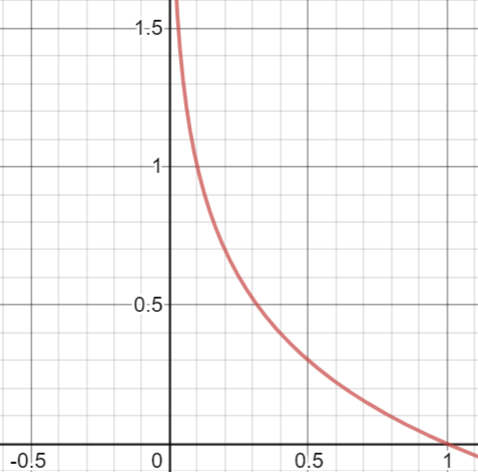

And for an example that is actually classified as 0, the cost of predicting it as a near 0 value will approach 0, while the cost of predicting it as a near 1 value will have it approach infinity. 

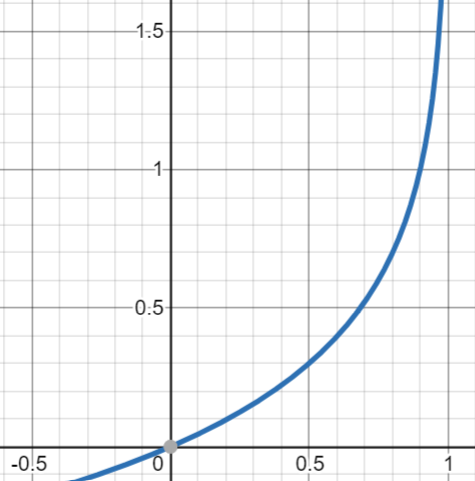


While we can use the above piecewise function to compute the average cost of the training set, we can merge both into a single one because of the property that y will always be either 1 or 0 for each example. Thus the cost function from above: 
### $$cost(h_\theta,y) =  \left\{
\begin{array}{ll}
      -log(h_\theta(x)) & y == 1 \\
      -log(1-h_\theta(x)) & y == 0 \\
\end{array} 
\right.  $$

can become:

### $$cost(h_\theta,y) = -ylog(h_\theta(x))+(1-y)(log(1-h_\theta(x))) $$
If y = 1: $$cost(h_\theta,y) = -log(h_\theta(x))+0 $$
If y = 0: $$cost(h_\theta,y) = 0 + (log(1-h_\theta(x))) $$


Then we just divide the total cost of all training examples with the total number of training examples in the dataset to find the average cost. 

In [9]:
def cost(pred, true):
  """Returns the cost of weights theta on dataset X with true labels y"""
  assert(pred.shape == true.shape)
  summation = (-true.T @ np.log(pred) - (1-true).T @ np.log(1-pred))
  return summation/m


A separate performance measurement that represents $\#correct/\#total$ for the predicted labels.

In [21]:
def accuracy(pred, true):
  # TODO: change pred to be vector of 0 or 1s
  m,_ = pred.shape
  diff = np.round(pred)-true
  return 1-np.sum(np.absolute(diff))/m


## 2.5 Gradient descent/Learning
Gradient descent is the actual learning part of the algorithm. 
It takes in parameters X: our mxn matrix of examples, values: our mx1 array of true values, theta: the parameters for our model, iters: the number of iterations to run gradient descent for, alpha: the learning rate. It outputs the final array of weights as well as a list of costs for each iteration. 

Intuitively, gradient descent just travels in the direction of smallest cost. 

In [13]:
def gradient_descent(X, y, theta, iters, alpha):
  """Performs gradient descent given starting weights theta, for iters iterations,
  with learning rate alpha, on dataset X with labels y"""
  m,n = X.shape
  assert(theta.shape == (n,1))
  assert(y.shape == (m,1))
  history = [None]*iters
  for i in range(iters):
    hypo = sigmoid(X @ theta)
    diff = hypo - y
    grad = (X.T @ diff)
    theta -= (alpha*grad/m)
    history[i] = cost(hypo,y)
  history.append(cost(sigmoid(X @ theta), y))
  return theta, history


Now that we have a working gradient descent algorithm, we can try and learn better values for theta. 

Run the cell below and you should see a huge improvement between the initial and final costs of our training data.

In [14]:
i_theta = init_theta(n)
x_norm, mean, std = feature_normalize(x_train)
x_append = np.append(x_norm, np.ones((split,1)), axis=1)
print(cost(sigmoid(x_append @ i_theta), y_train))
final_theta, history = gradient_descent(x_append, y_train, i_theta, 1000, .03)
# print(cost(x_append, y_train, final_theta))
print(history[-1])

[[0.48310258]]
[[0.23547407]]


# 3.0 Evaluation
We now have our model's $\theta$ and history. Just like last time, we plot the cost over iterations and see that it has decreased significantly. Something to note is how initially the improvement to error is huge with each step. However, as the model continues, the rate of improvement drops and eventually seems asymptotic. We can choose to run the gradient descent algorithm for however long we'd like, using even hundreds of thousands of iterations, yet at some point, the improvement we see is negligible. Furthermore, as we approach the best possible match for the training data, we risk overfitting the training set, and then would see a decrease in performance on the test data compared to a model that wasn't trained for as long. 

In [15]:
def plot_cost(hist):
    iters = list(range(len(hist)))
    df = pd.DataFrame({"Error": list(hist), "Iters": iters})
    ax = sns.lmplot(x="Iters", y="Error", data=df, fit_reg=False)
    plt.show()

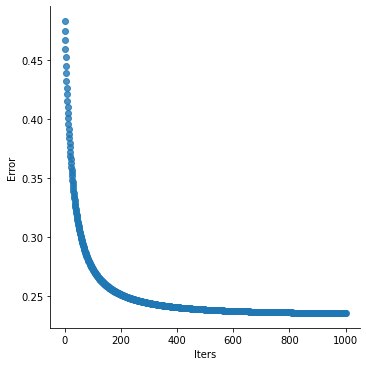

In [16]:
plot_cost(history)

You can experiment around with changing the number for iters in the gradient descent algorithm. You should see with large values for iters (>1000), the curve flattens out towards the end.

To evaluate our model on our test data, we must first scale the test data with the same mean and std as our training data. We also append the bias feature to each example, then run our predictions on it. 

In [26]:
x_test_norm = (x_test-mean)/std
x_test_norm = np.append(x_test_norm, np.ones((m-split,1)), axis=1)
pred = sigmoid(x_test_norm @ final_theta)
print("Cost on test set: (%f)" % cost(pred, y_test))
print("Accuracy on test set: (%f)" % accuracy(pred, y_test))

Cost on test set: (0.119848)
Accuracy on test set: (0.833333)


# 4.0 Using Machine Learning Libraries
While it's important to understand the details of how machine learning algorithms work and how they're implemented, manually implementing them each time is a lot of repeated work. We can instead use preassembled packages for many of the common machine learning algorithms, logistic regression being no exception. Below, with only 4 lines of code, we can create a classifier based on our dataset that performs just as well as our own implementation. Additionally, these machine learning libraries often allow for fine tuning, with many different parameters for creating their classifier. 

In [27]:
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression(random_state=0,solver="sag")
clf = logistic.fit(x_append, y_train.flatten())
test_preds = clf.predict_proba(x_test_norm).reshape((-1,1))
test_preds = test_preds[1::2]
print("Cost on test set: (%f)" % cost(test_preds, y_test))
print("Accuracy on test set: (%f)" % accuracy(test_preds, y_test))

Cost on test set: (0.119376)
Accuracy on test set: (0.833333)


# 4.0 Conclusion

In this notebook, we introduced the concept of classification algorithms, which instead of outputting any real number, is limited to either discrete values or in this case, a number ranging from (0,1) representing the probability that a specific example is a certain class. Logistic regression is a simple and powerful classification algorithm that is often used as a baseline algorithm for large tasks. Having the model not only learn to classify, but also give the probabilty of its predictions is incredibly powerful.

However, an issue we've seen in both notebooks so far is that they are both linear models. As such, for some datasets it's impossible to achieve any sort of usable model with purely using what we've gone over so far. And even though our current model achieves ~80% accuracy on our test set, for many tasks, being correct for 80% of the time is simply not high enough. There are ways to improve this, however.

#5.0 What's Next?

As hinted by in the conclusion, in our next notebook, we will explore methods of allowing previously linear classifiers find non-linear relationships. Doing so should allow our models achieve even higher accuracies. Futhermore, I'll introduce a new machine learning model called a Support Vector Machine (SVM). 

Thanks for checking out the second part of my AI/ML tutorial notebooks. More to come soon!